# Experiment with Generative Adversarial Network(GAN)

In this notebook, you will find me running series of experiment on GAN, see how we can control the contents that GAN generated

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import time
from IPython import display
from tensorflow.keras import layers

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, False)
  except RuntimeError as e:
    print(e)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Get the datas ready

In [9]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 8.8 MB/s eta 0:00:00


In [10]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/imaterialist-fashion-2019-FGVC6.7z",outdir="/content")

patool: Extracting /content/drive/MyDrive/imaterialist-fashion-2019-FGVC6.7z ...
patool: running /usr/bin/7z x -o/content -- /content/drive/MyDrive/imaterialist-fashion-2019-FGVC6.7z
patool: ... /content/drive/MyDrive/imaterialist-fashion-2019-FGVC6.7z extracted to `/content'.


'/content'

In [8]:
train_dir = '/content/imaterialist-fashion-2019-FGVC6/'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./127.5)
train_data = train_datagen.flow_from_directory(directory=train_dir,
                        batch_size=32,
                        target_size=(28,28),
                        class_mode='binary',
                        color_mode='grayscale',
                        seed=42)

Found 48388 images belonging to 2 classes.


Getting all x_train out from the dataset

In [ ]:
x_train = []
for i in range(len(train_data)):
    batch = train_data[i][0]
    batch_normalized = (batch / 127.5) - 1
    x_train.append(batch_normalized)
x_train = np.concatenate(x_train, axis=0)

In [ ]:
x_train.shape

(48388, 28, 28, 1)

In [16]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

## Build GAN model(OUTPUT Unsatisfied)

### Build the generator

In [ ]:
def build_generator(): 
    model = tf.keras.Sequential()
    # The model will first take 100 sample from the input shape, and it expand it into 7x7x256 dimension
    # and it has the feature of shape (7, 7, 256 now)
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) 
    # Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # Leaky relu can return negative numbers
    
    model.add(layers.Reshape((7, 7, 256)))
    # Check if the model output are true, if not the function will error out
    assert model.output_shape == (None, 7, 7, 256) # None is the batch size 
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1,1), padding='same', use_bias=False))
    # Check the output shape of previous layer
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # Leaky relu can return negative numbers
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # minimalize the size of the output until it output a images
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

Try to get an image with the untrained generator

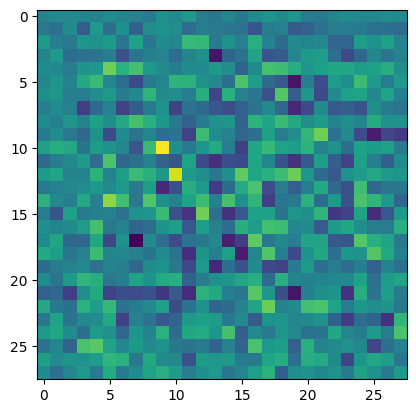

In [ ]:
generator = build_generator()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0])

In [ ]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)       

### Build the discriminator

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = build_discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00098535]], shape=(1, 1), dtype=float32)


### Define loss and optimizers

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-6)

### Getting ready to train the model

In [ ]:
import os
checkpoint_dir = './generation_model/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 8

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Train the model

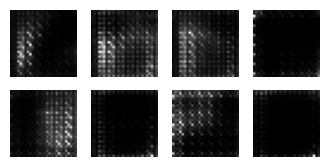

In [ ]:
train(train_ds, EPOCHS)

## Improve GAN
Trying to build another GAN with 3 channel inputs and see if it helps

### Preprocess the data

In [9]:
train_datagen_updated = ImageDataGenerator(rescale=1./255)
train_data_updated = train_datagen_updated.flow_from_directory(directory=train_dir,
                        batch_size=32,
                        target_size=(64,64),
                        class_mode='binary',
                        color_mode='rgb',
                        seed=42)

Found 48388 images belonging to 2 classes.


In [10]:
x_train_updated = []
for i in range(len(train_data_updated)):
    batch = train_data_updated[i][0]
    x_train_updated.append(batch)
x_train_updated = np.concatenate(x_train_updated, axis=0)

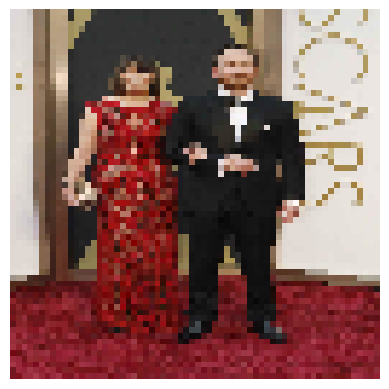

In [12]:
# Randomly plot an image
random_idx = np.random.randint(0, x_train_updated.shape[0])
plt.imshow(x_train_updated[random_idx])
plt.axis('off')
plt.show()

In [14]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [15]:
train_ds_updated = tf.data.Dataset.from_tensor_slices(x_train_updated).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds_updated = train_ds_updated.prefetch(tf.data.AUTOTUNE)

In [16]:
x_train_updated.shape

(48388, 64, 64, 3)

Create the generator

In [17]:
def build_generator(): 
    model = tf.keras.Sequential()
    # The model will first take 100 sample from the input shape, and it expand it into 7x7x256 dimension
    # and it has the feature of shape (7, 7, 256 now)
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(200,))) 
    # Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # Leaky relu can return negative numbers
    
    model.add(layers.Reshape((8, 8, 512)))
    # Check if the model output are true, if not the function will error out
    # assert model.output_shape == (None, 8, 8, 512) # None is the batch size 
    
    model.add(layers.Conv2DTranspose(512, (3, 3), strides=(1,1), padding='same', use_bias=False))
    # Check the output shape of previous layer
    # assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # Leaky relu can return negative numbers
    
    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # minimalize the size of the output until it output a images
    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 64, 64, 3)
    
    return model

model = build_generator()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             6553600   
                                                                 
 batch_normalization (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        2359296   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2

Create the discriminator

In [18]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU(alpha=0.5))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.5))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.5))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.5))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

model = build_discriminator()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)      

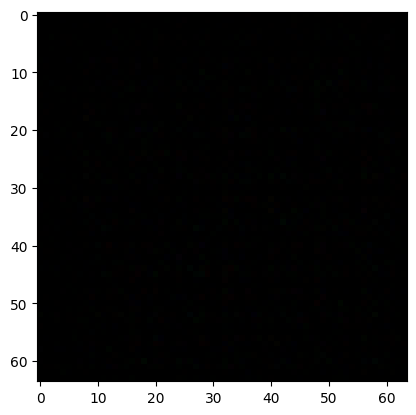

In [19]:
generator = build_generator()
noise = tf.random.normal([1, 200])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0])

In [20]:
discriminator = build_discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.0004854]], shape=(1, 1), dtype=float32)


Define loss and optimizers 

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-8)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-8)

In [25]:
import os

checkpoint_dir = './generation_model/training_checkpoints2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
EPOCHS = 100
noise_dim = 200
num_examples_to_generate = 8

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [28]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [29]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

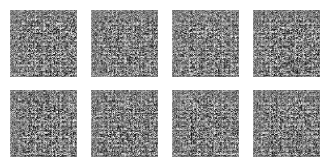

Time for epoch 68 is 111.82730746269226 sec


In [ ]:
train(train_ds_updated, EPOCHS)